In [1]:
import scanpy as sc
import glob

import numpy as np
import pandas as pd
import pickle as pkl

from geosketch import gs
from fbpca import pca

import numpy as np
import pickle

import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from uce_utils import read_uce_embed
plt.rcParams['svg.fonttype'] = 'none'

from cell_type_map_gpt import cell_type_mapping

import sys
sys.path.append('/dfs/user/yhr/cross-species-coarse/')
import matplotlib.pyplot as plt
from cs_utils import plotly_scatter

import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
lung_datasets =\
['3de0ad6d-4378-4f62-b37b-ec0b75a50d94',
 '8c42cfd0-0b0a-46d5-910c-fc833d83c45e',
 '576f193c-75d0-4a11-bd25-8676587e6dc2',
 '1b9d8702-5af8-4142-85ed-020eb06ec4f6',
 '9f222629-9e39-47d0-b83f-e08d610c7479',
 '3dc61ca1-ce40-46b6-8337-f27260fd9a03',
 'f9846bb4-784d-4582-92c1-3f279e4c6f0c',
 'd8da613f-e681-4c69-b463-e94f5e66847f',
 '2f132ec9-24b5-422f-9be0-ccef03b4fe28',
 '1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1',
 'e04daea4-4412-45b5-989e-76a9be070a89']

### UCE embedding (33 layer)

In [3]:
uces_adatas = []
sample_size = 20000

for itr, d in enumerate(lung_datasets):
    try:
        adata_ = read_uce_embed(d, model='33layer')
        sc.pp.subsample(adata_, min(len(adata_), sample_size)/len(adata_), random_state=0)
        adata_.obs['dataset']=itr
        uces_adatas.append(adata_)
    except:
        print(d)
        pass
    
uce_adata_33lay = sc.concat(uces_adatas)

/dfs/user/yhr/deepamp/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
import time

start_time = time.time()
sc.pp.neighbors(uce_adata_33lay)
sc.tl.umap(uce_adata_33lay)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [4]:
uce_adata_33lay.obs['cell_type_coarse'] = uce_adata_33lay.obs['cell_type'].map(cell_type_mapping)
uce_adata_33lay.obs['cell_type_coarse'] = pd.Categorical(uce_adata_33lay.obs['cell_type_coarse'])
uce_adata_33lay.obs['dataset'] = uce_adata_33lay.obs['dataset'].astype('str')

In [ ]:
plt.figure(figsize=[10,8])
ax = plt.gca()
sc.pl.umap(uce_adata, color='dataset', ax=ax, s=1)

plt.figure(figsize=[12,10])
ax = plt.gca()
sc.pl.umap(uce_adata, color='cell_type_coarse', ax=ax, s=1)

### Tabula mapping

In [5]:
tabula_uce = sc.read_h5ad('/dfs/project/cross-species/uce/new_tabula_sapiens_ep_8_sn_2013249_nlayers_33_sample_size_1024.h5ad')
TSv2 = True
TSv1_include = True

tabula_lung = tabula_uce[tabula_uce.obs['tissue']=='Lung']
tabula_lung_33lay = sc.AnnData(tabula_lung.obsm['X_uce'])
tabula_lung_33lay.obs = pd.DataFrame(tabula_lung.obs)
tabula_lung_33lay.obs['cell_type'] = tabula_lung_33lay.obs['cell_ontology_class']

if TSv2:
    tabula_lung_33lay_seen = tabula_lung_33lay[tabula_lung_33lay.obs['donor'].isin([f'TSP{x}' for x in np.arange(0,16)])]
    tabula_lung_33lay = tabula_lung_33lay[tabula_lung_33lay.obs['donor'].isin([f'TSP{x}' for x in np.arange(16,31)])]  
    

In [6]:
tabula_lung_33lay.obs['dataset'] = 'TS'
tabula_lung_33lay_seen.obs['dataset'] = 'TS_Seen'

/tmp/user/20138/ipykernel_4090948/3058193479.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tabula_lung_33lay.obs['dataset'] = 'TS'
/tmp/user/20138/ipykernel_4090948/3058193479.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tabula_lung_33lay_seen.obs['dataset'] = 'TS_Seen'


In [7]:
if TSv1_include:
    uce_map = sc.concat([uce_adata_33lay, tabula_lung_33lay_seen, tabula_lung_33lay])
else:
    uce_map = sc.concat([uce_adata_33lay, tabula_lung_33lay])

/dfs/user/yhr/deepamp/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
import time

start_time = time.time()
sc.pp.neighbors(uce_map)
sc.tl.umap(uce_map)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

         Falling back to preprocessing with `sc.pp.pca` and default params.
Execution time: 257.6943402290344 seconds


In [10]:
#TS_map_only = uce_map[uce_map.obs['dataset'].isin(['TS', 'TS_Seen'])]

In [8]:
uce_map.obs['cell_type_coarse'] = uce_map.obs['cell_type'].map(cell_type_mapping)
uce_map.obs['cell_type_coarse'] = pd.Categorical(uce_map.obs['cell_type_coarse'])
uce_map.obs['dataset'] = uce_map.obs['dataset'].astype('str')

In [561]:
#no_TS_map = uce_map[~uce_map.obs['dataset'].isin(['TS', 'TS_Seen'])]

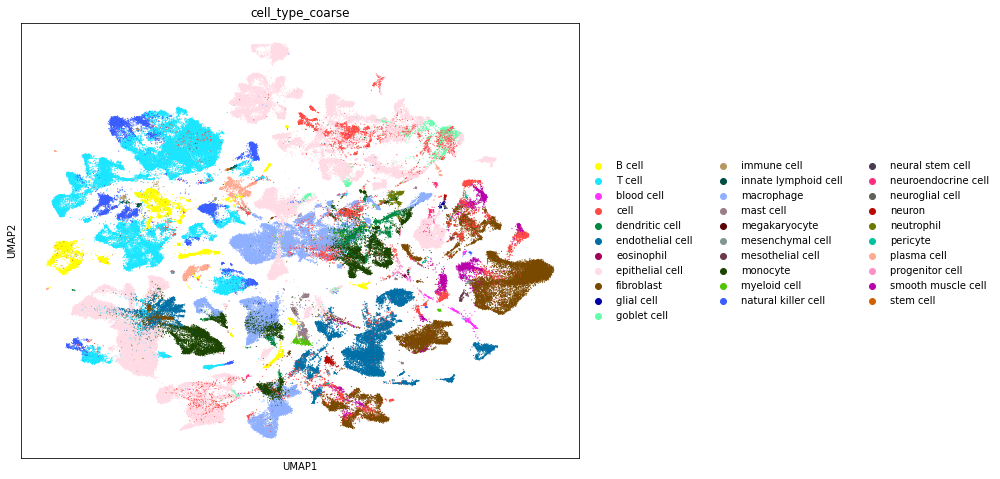

In [565]:
plt.figure(figsize=[10,8])
ax = plt.gca()
sc.pl.umap(no_TS_map, color='cell_type_coarse', ax=ax, s=5)


In [14]:
uce_map.uns['dataset_colors'][-2] = '#C00000'

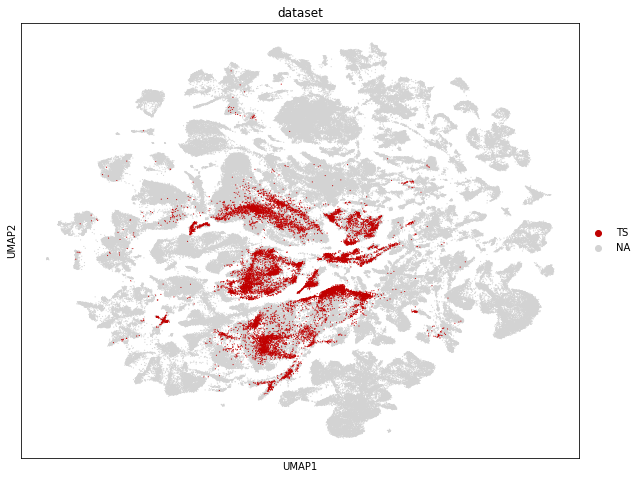

In [15]:
plt.figure(figsize=[10,8])
ax = plt.gca()
sc.pl.umap(uce_map, color='dataset', groups= ['TS'], ax=ax, s=5)

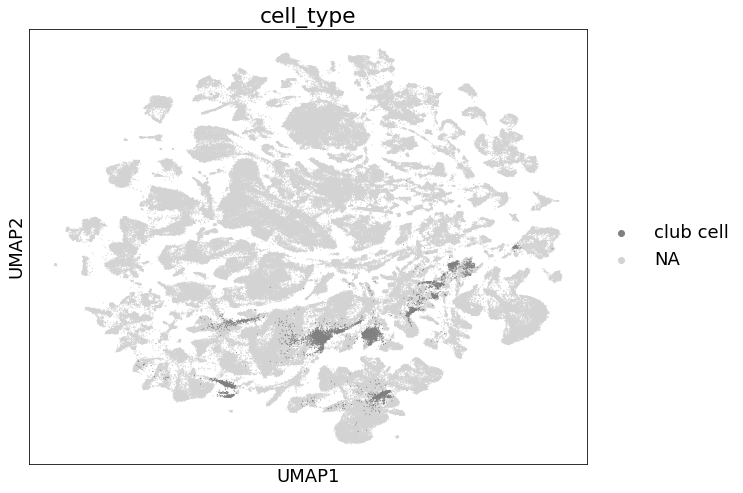

In [46]:
plt.figure(figsize=[10,8])
ax = plt.gca()
sc.pl.umap(uce_map, color='cell_type', groups= ['club cell'], ax=ax, s=5)


In [519]:
#plotly_scatter(uce_map, label='dataset', hover_cols=['cell_type', 'cell_type_coarse'])

In [520]:
#plotly_scatter(uce_map, label='cell_type_coarse', hover_cols=['cell_type', 'dataset'])

In [9]:
uce_map.obs['cell_type'] = [x.split('_TS')[0] for x in uce_map.obs['cell_type']]
uce_map.obs['cell_type'] = uce_map.obs['cell_type'].astype('str')
uce_map.obs['cell_type_coarse'] = uce_map.obs['cell_type_coarse'].astype('str')

cell_types = uce_map.obs['cell_type'].values
coarse_cell_types = uce_map.obs['cell_type_coarse'].values

if TSv1_include:
    cell_types[245247:] = [x+ ' (New)' for x in cell_types[245247:] ]
    coarse_cell_types[245247:] = [x+ ' (New)' for x in coarse_cell_types[245247:] ]
else:
    cell_types[189585:] = [x+ ' (New)' for x in cell_types[189585:] ]
    coarse_cell_types[189585:] = [x+ ' (New)' for x in coarse_cell_types[189585:] ]

uce_map.obs['cell_type'] = pd.Categorical(cell_types)
uce_map.obs['cell_type_coarse'] = pd.Categorical(coarse_cell_types)

### Dendrograms

In [10]:
## Standardize cell type names

uce_map.obs['cell_type'] = [x.title() for x in uce_map.obs['cell_type']]

mapping_dict = {x:x for x in uce_map.obs['cell_type'].values}
mapping_dict.update({'Type Ii Pneumocyte': 'Type II Pneumocyte'})
mapping_dict.update({'Type Ii Pneumocyte (New)': 'Type II Pneumocyte (New)'})

uce_map.obs['cell_type'] = pd.Categorical(uce_map.obs['cell_type'].map(mapping_dict))

mapping_dict = {x:x for x in uce_map.obs['cell_type'].values}
mapping_dict.update({x:x.replace('Cd', 'CD') for x in uce_map.obs['cell_type'].unique() if 'Cd' in x})

uce_map.obs['cell_type'] = pd.Categorical(uce_map.obs['cell_type'].map(mapping_dict))

In [11]:
import matplotlib

font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [15]:
#uce_adata_4lay_clean = uce_adata_4lay[uce_adata_4lay.obs['cell_type_coarse']!='cell']
#uce_map_clean = uce_map[uce_map.obs['cell_type_coarse']!='cell']
#sc.pp.neighbors(uce_adata_4lay_clean)

### Coarse dendrogram

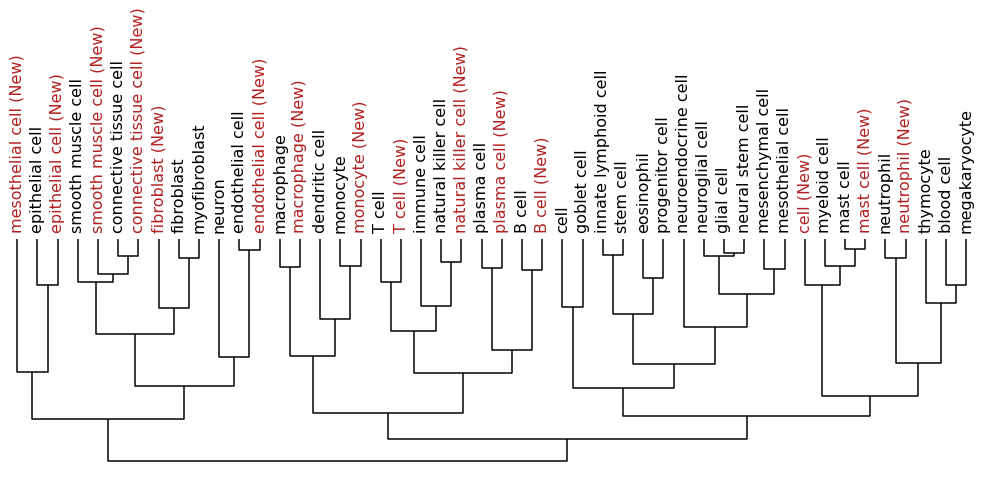

In [26]:
## Make colored denrogram
linkage_matrix = uce_map.uns['dendrogram_cell_type_coarse']['linkage']

# Your data loading code here...
categories = uce_map.obs['cell_type_coarse'].cat.categories

# Calculate the dendrogram
plt.figure(figsize=[14,7])
leaf_colors = lambda x: 'firebrick' if ' (New)' in categories[x] else 'black'

dendro = dendrogram(linkage_matrix, 
                    leaf_label_func=lambda x: categories[x], 
                    color_threshold=None,
                    orientation='bottom',
                    link_color_func=lambda x: 'black')  # Color for branches

# Increase font size and apply custom leaf coloring
leaf_font_size = 16  # Adjust this value to your preference
for i, d in enumerate(dendro['leaves']):
    label = plt.gca().get_xticklabels()[i]
    label.set_color(leaf_colors(d))
    label.set_fontsize(leaf_font_size)

# Remove y-axis labels and bounding box
plt.gca().get_yaxis().set_visible(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Show the plot
plt.tight_layout()  # Ensures that all labels are displayed properly
plt.show()


### Linear Dendrogram

In [88]:
sc.tl.dendrogram(uce_map, groupby='cell_type')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
/tmp/user/20138/ipykernel_4090948/362051578.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()  # Ensures that all labels are displayed properly


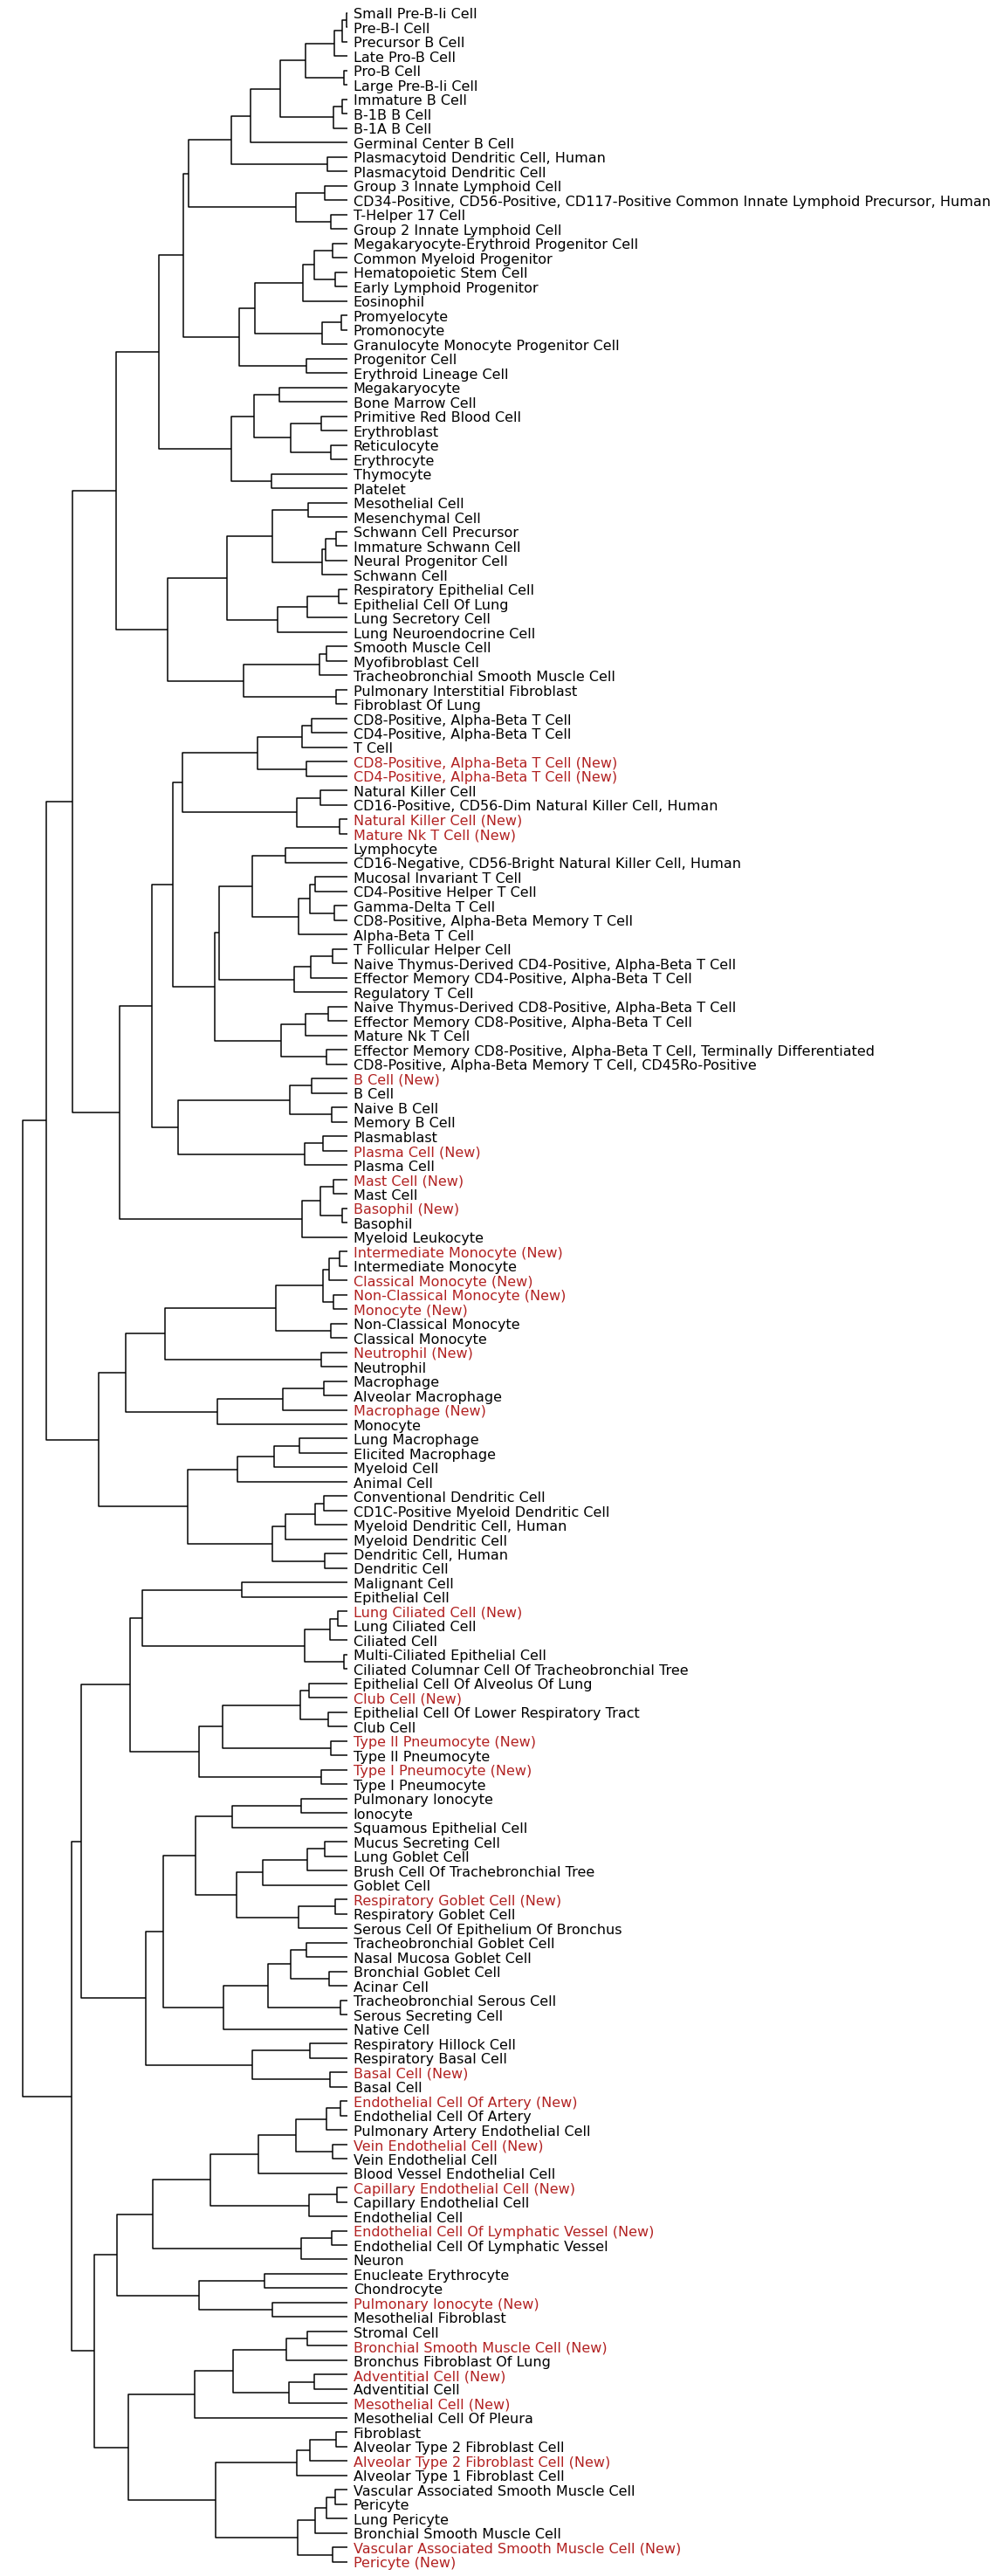

In [13]:
### NEW
## Make colored denrogram
linkage_matrix = uce_map.uns['dendrogram_cell_type']['linkage']

# Your data loading code here...
categories = uce_map.obs['cell_type'].cat.categories

# Calculate the dendrogram
plt.figure(figsize=[7, 54])
leaf_colors = lambda x: 'firebrick' if ' (New)' in categories[x] else 'black'

dendro = dendrogram(linkage_matrix, 
                    leaf_label_func=lambda x: categories[x], 
                    color_threshold=None,
                    orientation='left',
                    link_color_func=lambda x: 'black')  # Color for branches

# Increase font size and apply custom leaf coloring
leaf_font_size = 16  # Adjust this value to your preference
for i, d in enumerate(dendro['leaves']):
    label = plt.gca().get_yticklabels()[i]
    label.set_color(leaf_colors(d))
    label.set_fontsize(leaf_font_size)

# Remove y-axis labels and bounding box
plt.gca().get_xaxis().set_visible(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Show the plot
plt.tight_layout()  # Ensures that all labels are displayed properly
plt.savefig('fig3c.svg')
plt.show()


### Radial dendrogram

In [80]:
## ONLY run this for radial dendrogram

uce_map.obs['cell_type'] = [x.replace("[New]", "-New") for x in uce_map.obs['cell_type']]
uce_map.obs['cell_type'] = [x.replace(",", '') for x in uce_map.obs['cell_type']]
uce_map.obs['cell_type'] = pd.Categorical(uce_map.obs['cell_type'])
sc.tl.dendrogram(uce_map, 'cell_type')

In [81]:
from scipy.cluster import hierarchy

def get_newick(node, parent_dist, leaf_names, newick='') -> str:
    """
    Convert sciply.cluster.hierarchy.to_tree()-output to Newick format.

    :param node: output of sciply.cluster.hierarchy.to_tree()
    :param parent_dist: output of sciply.cluster.hierarchy.to_tree().dist
    :param leaf_names: list of leaf names
    :param newick: leave empty, this variable is used in recursion.
    :returns: tree in Newick format
    """
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parent_dist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parent_dist - node.dist, newick)
        else:
            newick = ");"
        newick = get_newick(node.get_left(), node.dist, leaf_names, newick=newick)
        newick = get_newick(node.get_right(), node.dist, leaf_names, newick=",%s" % (newick))
        newick = "(%s" % (newick)
        return newick

    

tree = hierarchy.to_tree(uce_map.uns['dendrogram_cell_type']['linkage'], 
                         False)
get_newick(tree, tree.dist, 
           uce_map.obs['cell_type'].cat.categories.tolist())
           #uce_map.uns['dendrogram_cell_type']['categories_ordered'])

'((((((((((((((Small Pre-B-Ii Cell:0.00,Pre-B-I Cell:0.00):0.02,Precursor B Cell:0.02):0.04,Late Pro-B Cell:0.06):0.14,(Pro-B Cell:0.02,Large Pre-B-Ii Cell:0.02):0.18):0.12,((Immature B Cell:0.03,B-1B B Cell:0.03):0.04,B-1A B Cell:0.07):0.25):0.14,Germinal Center B Cell:0.46):0.09,(Plasmacytoid Dendritic Cell Human:0.09,Plasmacytoid Dendritic Cell:0.09):0.45):0.20,((Group 3 Innate Lymphoid Cell:0.11,CD34-Positive CD56-Positive CD117-Positive Common Innate Lymphoid Precursor Human:0.11):0.13,(T-Helper 17 Cell:0.08,Group 2 Innate Lymphoid Cell:0.08):0.16):0.51):0.02,(((((Megakaryocyte-Erythroid Progenitor Cell:0.07,Common Myeloid Progenitor:0.07):0.09,(Hematopoietic Stem Cell:0.06,Early Lymphoid Progenitor:0.06):0.10):0.05,Eosinophil:0.21):0.23,((Promyelocyte:0.03,Promonocyte:0.03):0.09,Granulocyte Monocyte Progenitor Cell:0.12):0.32):0.07,(Progenitor Cell:0.19,Erythroid Lineage Cell:0.19):0.32):0.27):0.12,(((Megakaryocyte:0.32,Bone Marrow Cell:0.32):0.12,((Primitive Red Blood Cell:0.12,

### Locating cell types on umap

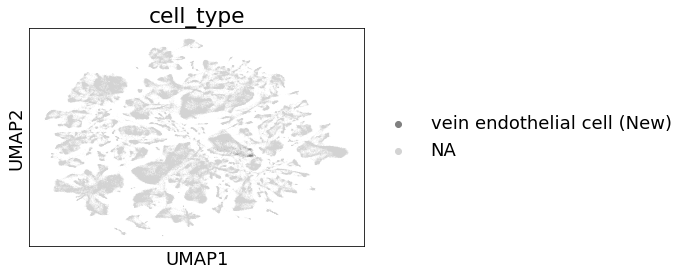

In [38]:
sc.pl.umap(uce_map, color='cell_type', groups='vein endothelial cell (New)')

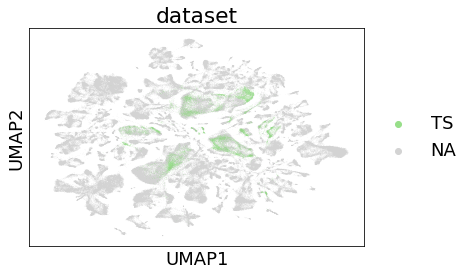

In [27]:
sc.pl.umap(uce_map, color='dataset', groups='TS')